In [9]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# Authors: Maxime Goffart and Olivier Joris

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score

def load_data(data_path):
    """
    Load the data for the classifer.
    Method given with the assignment. Authors: Antonio Sutera & Yann Claess.

    Argument:
    ---------
    - `data_path`: Path to the data folder.
    """

    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_train, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_train[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_train = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_train size: {}.'.format(X_train.shape))
    print('y_train size: {}.'.format(y_train.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_train, y_train, X_test

# Author: Antonio Sutera & Yann Claess
def write_submission(y, where, submission_name='toy_submission.csv'):
    """
    Method given with the assignment. Authors: Antonio Sutera & Yann Claess.

    Arguments:
    ----------
    - `y`: Predictions to write.
    - `where`: Path to the file in which to write.
    - `submission_name`: Name of the file.
    """

    os.makedirs(where, exist_ok=True)

    SUBMISSION_PATH = os.path.join(where, submission_name)
    if os.path.exists(SUBMISSION_PATH):
        os.remove(SUBMISSION_PATH)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(SUBMISSION_PATH, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print('Submission {} saved in {}.'.format(submission_name, SUBMISSION_PATH))

def compute_proportion_subjects():
    """
    Compute the proportions of the subjects and the activities.
    """

    LS = np.loadtxt(os.path.join('data/LS', 'subject_Id.txt'))
    activity = np.loadtxt(os.path.join('data/LS', 'activity_Id.txt'))

    unique_activity, count_activity = np.unique(activity, return_counts = True)
    unique_ls, count_ls = np.unique(LS, return_counts = True)
    
    plt.bar(unique_activity, count_activity, width=0.5, bottom=None, align='center', data=None)
    plt.title("Repartition of the activties in the learning set")
    plt.xlabel("activity id")
    plt.ylabel("number of instances")
    plt.show()
    
    plt.bar(unique_ls, count_ls, width=0.5, bottom=None, align='center', data=None)
    plt.title("Repartition of the subject id in the learning set")
    plt.xlabel("subject id")
    plt.ylabel("number of instances")
    plt.show()

In [2]:
if __name__ == '__main__':
    # Directory containing the data folders
    DATA_PATH = 'data'
    X_train, y_train, X_test = load_data(DATA_PATH)

X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


In [3]:
    # Replace missing values
    imputer = KNNImputer(n_neighbors = 5, weights = 'distance', missing_values = -999999.99)
    X_train = imputer.fit_transform(X_train)

In [7]:
    # Feature selection
    etc = ExtraTreesClassifier(random_state = 0)
    print("Shape before feature selection: " + str(X_train.shape))
    
    selector = SelectFromModel(estimator = etc).fit(X_train, y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    print("Shape after feature selection: " + str(X_train.shape))

Shape before feature selection: (3500, 15872)
Shape after feature selection: (3500, 3607)


/home/olivierjoris/miniconda3/envs/ELEN0062/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/olivierjoris/miniconda3/envs/ELEN0062/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


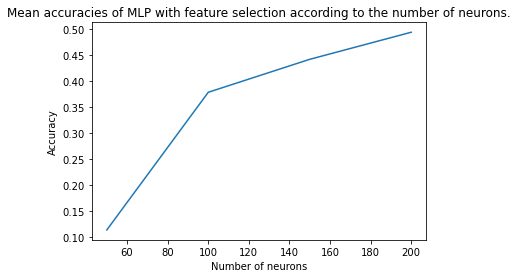

In [13]:
    LS_path = os.path.join(DATA_PATH, 'LS')   
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    
    iter_nb = 5
    
    ids = [1, 2, 3, 4, 5]
    learning_id = [0, 0, 0]   
    scores = np.zeros(iter_nb)
    
    random.seed()
    
    learning_id = [0,0,0]
    
    gen_score = []
    number_neurons = []
    
    for x in range(50, 250, 50):
        for j in range(iter_nb):
            random.shuffle(ids)

            for i in range(3):
                learning_id[i] = ids[i]

            unique_ls, count_ls = np.unique(LS_subject_id, return_counts = True)

            count = np.asarray((unique_ls, count_ls))

            training_size = int(count[1][learning_id[0] - 1] + count[1][learning_id[1] - 1] + count[1][learning_id[2] - 1])

            X_train_split = np.zeros((training_size, X_train.shape[1]))
            X_test_split = np.zeros((3500 - training_size, X_test.shape[1]))

            y_train_split = np.zeros((training_size))
            y_test_split = np.zeros((3500 - training_size))

            training_current_size, testing_current_size = 0, 0

            for i in range(3500):
                if LS_subject_id[i] in learning_id:
                    X_train_split[training_current_size] = X_train[i]
                    y_train_split[training_current_size] = y_train[i]
                    training_current_size += 1
                else:
                    X_test_split[testing_current_size] = X_train[i]
                    y_test_split[testing_current_size] = y_train[i]
                    testing_current_size += 1

            rf = MLPClassifier(random_state = 0, hidden_layer_sizes = (x,)).fit(X_train_split, y_train_split)
            y_pred = rf.predict(X_test_split)
            scores[j] = accuracy_score(y_test_split, y_pred)

        gen_score.append(np.mean(scores))
        number_neurons.append(x)
              
    plt.plot(number_neurons, gen_score)
    plt.xlabel("Number of neurons")
    plt.ylabel("Accuracy")
    plt.title("Mean accuracies of MLP with feature selection according to the number of neurons.")
    plt.savefig('MLP_feature_selection_neurons.png')
    plt.show()

/home/olivierjoris/miniconda3/envs/ELEN0062/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/olivierjoris/miniconda3/envs/ELEN0062/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/olivierjoris/miniconda3/envs/ELEN0062/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


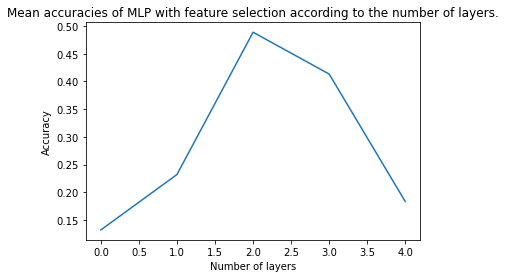

In [14]:
    LS_path = os.path.join(DATA_PATH, 'LS')   
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    
    iter_nb = 5
    
    ids = [1, 2, 3, 4, 5]
    learning_id = [0, 0, 0]   
    scores = np.zeros(iter_nb)
    
    random.seed()
    
    learning_id = [0,0,0]
    
    gen_score = []
    number_layers = []
    layers = [50]
    
    for x in range(5):
        for j in range(iter_nb):
            random.shuffle(ids)

            for i in range(3):
                learning_id[i] = ids[i]

            unique_ls, count_ls = np.unique(LS_subject_id, return_counts = True)

            count = np.asarray((unique_ls, count_ls))

            training_size = int(count[1][learning_id[0] - 1] + count[1][learning_id[1] - 1] + count[1][learning_id[2] - 1])

            X_train_split = np.zeros((training_size, X_train.shape[1]))
            X_test_split = np.zeros((3500 - training_size, X_test.shape[1]))

            y_train_split = np.zeros((training_size))
            y_test_split = np.zeros((3500 - training_size))

            training_current_size, testing_current_size = 0, 0

            for i in range(3500):
                if LS_subject_id[i] in learning_id:
                    X_train_split[training_current_size] = X_train[i]
                    y_train_split[training_current_size] = y_train[i]
                    training_current_size += 1
                else:
                    X_test_split[testing_current_size] = X_train[i]
                    y_test_split[testing_current_size] = y_train[i]
                    testing_current_size += 1

            rf = MLPClassifier(random_state = 0, hidden_layer_sizes = layers).fit(X_train_split, y_train_split)
            y_pred = rf.predict(X_test_split)
            scores[j] = accuracy_score(y_test_split, y_pred)

        gen_score.append(np.mean(scores))
        number_layers.append(x)
        layers.append(50)
              
    plt.plot(number_layers, gen_score)
    plt.xlabel("Number of layers")
    plt.ylabel("Accuracy")
    plt.title("Mean accuracies of MLP with feature selection according to the number of layers.")
    plt.savefig('MLP_feature_selection_layers.png')
    plt.show()